# Datos Calar Alto

In [1]:
import os 
import numpy as np
from astropy.io import fits
from IPython.display import Image
from scipy import stats
from functions_maxi import my_plot, my_plot_log, cut_master_frames, sky_squares_median, SkyInteractive

C:\Users\Maxi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_path = os.path.join('.', 'TFG_EXP_2022')
fits_files = os.listdir(data_path)

In [3]:
def file_path(fits_file):
    return os.path.join(data_path, fits_file)
file_paths = np.vectorize(file_path)

In [4]:
fits_files = file_paths(fits_files)

In [5]:
def hdu_open(fits_file):
    # given the path of a file it open the hdu
    return fits.open(fits_file)
hdu_open = np.vectorize(hdu_open)

In [6]:
hdu_2022 = hdu_open(fits_files)

In [7]:
def header_object(hdu):
    # returns the info: Object, Naxis1, Naxis2, Exposure Time
    return hdu[0].header['OBJECT'], hdu[0].header['NAXIS1'], hdu[0].header['NAXIS2'], hdu[0].header['EXPTIME']
def data_object(hdu):
    # returns the info: Object, Naxis1, Naxis2
    return hdu[0].data
#list(map(header_object, hdu_2022))

def file_mask(hdu):
    if 'img' in hdu[0].header['OBJECT']:
        # True for the bias frames we need
        return True
    elif 'dome R 50W' in hdu[0].header['OBJECT']:
        return True
    elif 'dome B 50W' in hdu[0].header['OBJECT']:
        return True
    elif 'dome V 50W' in hdu[0].header['OBJECT']:
        return True
    elif 'skyflat Halpha' in hdu[0].header['OBJECT']:
        return True
    elif 'NGC' in hdu[0].header['OBJECT']:
        return True
    else:
        return False
    
mask = list(map(file_mask, hdu_2022))
hdu_science = hdu_2022[mask]
science_data = np.array(list(map(data_object, hdu_science)), dtype = object)

hdu_science_info = np.array(list(map(header_object, hdu_science)), dtype = str)
print(hdu_science_info)

[['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[bias] img' '1601' '1601' '0.0']
 ['[flat] dome R 50W' '1601' '1601' '0.9']
 ['[flat] dome R 50W' '1601' '1601' '0.9']
 ['[flat] dome R 50W' '1601' '1601' '0.9']
 ['[flat] dome R 50W' '1601' '1601' '0.9']
 ['[flat] dome R 50W' '1601' '1601' '0.9']
 ['[flat] dome V 50W' '1601' '1601' '4.0']
 ['[flat] dome V 50W' '1601' '1601' '4.0']
 ['[flat] dome V 50W' '1601' '1601' '4.0']
 ['[flat] dome V 50W' '1601' '1601' '4.0']
 ['[flat] dome V 50W' '1601' '1601' '4.0']
 ['[flat] dome B 50W' '1601' '1601' '22.0']
 ['[flat] dome B 50W' '1601' '1601' '22.0']
 ['[flat] dome B 50W' '1601' '1601' '22.0']
 ['[flat] dome B 50W' '1601' '1601' '22.0']
 ['[flat] dome B 50W' '1601' '1601

## Alineacion con las Coordenadas de la CCD
The entry "DATASEC" of the header gives the (0,0) of each image in the CCD coordinates but for the data reduction we need the images to be aligned in such a way that each pixel of each image (calibration of science) represents the same pixel of the CCD. Hence, we make the cut in the calibration image taking into account that the science image is displaced,

$$\delta_x^{cal} = x1_{sci}^{CCD} - x1_{cal}^{CCD}$$

$$\delta_y^{cal} = y1_{sci}^{CCD} - y1_{cal}^{CCD}$$

with respect to the calibration image origin, as shown in the image bellow.



In [8]:
Image(url = 'Images/CCD_map.png', width = 350, height = 200)

### Index slicing: Creating the mask for each type of image

Boolean type vector.

In [9]:
mask_bias_frames = np.char.find(hdu_science_info[:,0], 'bias') == 1
mask_flats_frames = np.char.find(hdu_science_info[:,0], 'flat') == 1
mask_sci_frames = np.char.find(hdu_science_info[:,0], 'NGC') == 0

In [10]:
def header_datasec(hdu):
    # returns the info: Datasec
    # given the primary object of an HDU 
    replaced = hdu[0].header['DATASEC'].replace('[', '').replace(']', '').replace(':', ',')
    x1, y1, x2, y2 = replaced.split(',')
    return int(x1), int(y1), int(x2), int(y2)

# display info:
print('CCD coor. (x1, y1, x2, y2)\n')

# bias dataset coordinates:
x1_bias, y1_bias, x2_bias, y2_bias = header_datasec(hdu_science[mask_bias_frames][0])
print('BIAS: ', x1_bias, y1_bias, x2_bias, y2_bias)

# flats dataset coordinates:
print('FLATS: ')
x1_dome, y1_dome, x2_dome, y2_dome =  header_datasec(hdu_science[mask_flats_frames][0])
print('\t-DOME: ', x1_dome, y1_dome, x2_dome, y2_dome)
x1_sky, y1_sky, x2_sky, y2_sky = header_datasec(hdu_science[mask_flats_frames][-1])
print('\t-SKY:  ', x1_sky, y1_sky, x2_sky, y2_sky)

# science dataset coordinates:
x1_sci, y1_sci, x2_sci, y2_sci = header_datasec(hdu_science[mask_sci_frames][0])
print('SCIENCE: ', x1_sci, y1_sci, x2_sci, y2_sci)

CCD coor. (x1, y1, x2, y2)

BIAS:  200 200 1800 1800
FLATS: 
	-DOME:  200 200 1800 1800
	-SKY:   513 513 1536 1536
SCIENCE:  513 513 1536 1536


## Master Bias

In [11]:
mask_bias_frames

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [12]:
# using the mask we select the data that correspond to the bias calibration images
bias_data = science_data[mask_bias_frames]
# change the arrays of arrays to a unique array such that we have 10 cal images (sum mask) and the appropiate dims
bias_data = np.concatenate(bias_data).reshape(sum(mask_bias_frames), 1601, 1601)

In [13]:
master_bias = np.nanmedian(bias_data, axis = 0)

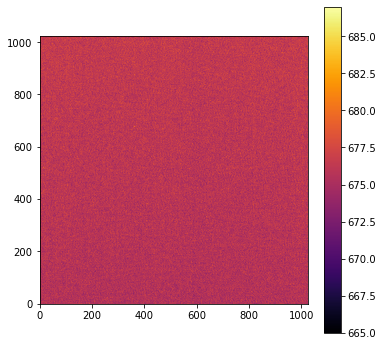

(1024, 1024)

In [14]:
master_bias_cut = cut_master_frames(master_bias, x1_sci - x1_bias, y1_sci - y1_bias, (1024, 1024))
my_plot(master_bias_cut)
master_bias_cut.shape

## Master Flats

In [15]:
mask_flats_frames

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False])

In [16]:
flats_type = hdu_science_info[mask_flats_frames][:, 0]
flats_cal = science_data[mask_flats_frames]

In [17]:
flats_data = {}
for key, data in zip(flats_type, flats_cal):
    if 'dome' in key: x1_flats = x1_dome; y1_flats = y1_dome; 
    else: x1_flats = x1_sky; y1_flats = y1_sky;
    
    if key not in flats_data:
        flats_data[key] = []
        raw_flats = data - cut_master_frames(master_bias, x1_sci - x1_flats, y1_sci - y1_flats, np.array(data).shape) 
        raw_flats /= np.nanmedian(raw_flats)
        flats_data[key].append(raw_flats)
    else:
        raw_flats = data - cut_master_frames(master_bias, x1_sci - x1_flats, y1_sci - y1_flats, np.array(data).shape)
        raw_flats /= np.nanmedian(raw_flats)
        flats_data[key].append(raw_flats)
flats_data.keys()

dict_keys(['[flat] dome R 50W', '[flat] dome V 50W', '[flat] dome B 50W', '[flat] skyflat Halpha'])

### Hacemos la mediana de todas las exposiciones y recortamos los flats si es necesario

In [18]:
master_flats = {}
for key, data in flats_data.items():
    if 'dome' in key: x1_flats = x1_dome; y1_flats = y1_dome; 
    else: x1_flats = x1_sky; y1_flats = y1_sky;
    master_flats[key] = cut_master_frames(np.nanmedian(np.array(data), axis = 0), 
                                          x1_sci - x1_flats, y1_sci - y1_flats, 
                                          (1024, 1024))

[flat] dome R 50W


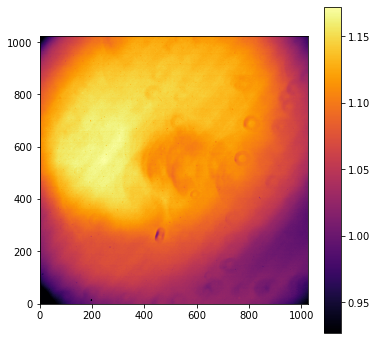

[flat] dome V 50W


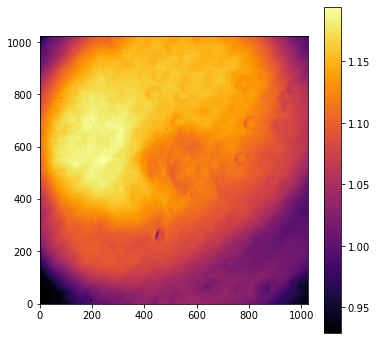

[flat] dome B 50W


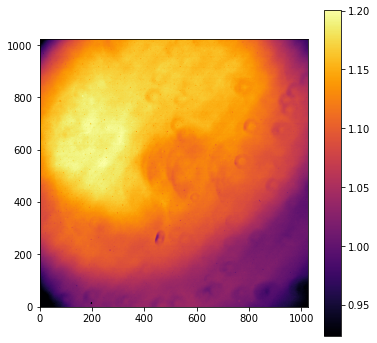

[flat] skyflat Halpha


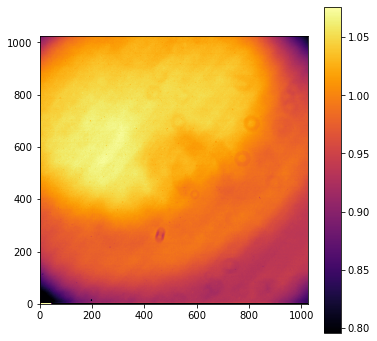

In [19]:
for key, value in master_flats.items():
    print(key)
    my_plot(value)
    value.shape

## Science image reduction

In [20]:
mask_sci_frames

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [21]:
# find the name of the filters used in the observation to name the entry of the dictionary 
list(np.unique(hdu_science_info[mask_sci_frames][:, 0]))

['NGC 5395 B', 'NGC 5395 Halpha', 'NGC 5395 R', 'NGC 5395 V']

In [22]:
# rehacemos el dic de flats con las nuevas keys
master_flats = dict([(key, value) for key, value in zip(['NGC 5395 R', 
                                                         'NGC 5395 V', 
                                                         'NGC 5395 B',
                                                         'NGC 5395 Halpha'], 
                                                          master_flats.values())
                    ])

In [23]:
def clean_saturated_pixels(image, N_sat = 55000):#2e16 - 1):
    image = image.astype(float)
    sat_pixels = (image >= N_sat)
    image[sat_pixels] = np.nan
    return image
def set_zero_to_nan(image):
    image = image.astype(float)
    zero_pixels = (image <= 0)
    image[zero_pixels] = np.nan
    return image

In [24]:
sci_data = {}
i = 0
for key, data in zip(hdu_science_info[mask_sci_frames][:, 0], science_data[mask_sci_frames]):
    EXPTIME = float(hdu_science_info[mask_sci_frames][:, 3][i])
    data = clean_saturated_pixels(data)
    if key not in sci_data:
        sci_data[key] = []
        raw_sci = (data - master_bias_cut)/(set_zero_to_nan(master_flats[key]*EXPTIME))
        sci_data[key].append(raw_sci)
    else:
        raw_sci = (data - master_bias_cut)/(set_zero_to_nan(master_flats[key]*EXPTIME))
        sci_data[key].append(raw_sci)
    i += 1
sci_data.keys()

dict_keys(['NGC 5395 R', 'NGC 5395 B', 'NGC 5395 V', 'NGC 5395 Halpha'])

NGC 5395 R


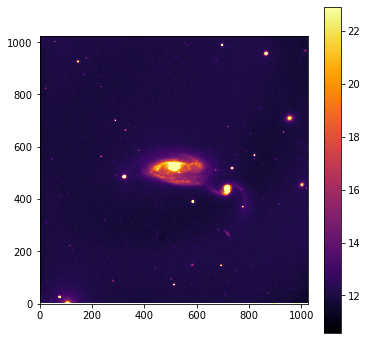

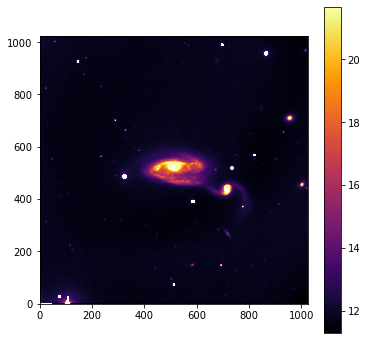

NGC 5395 B


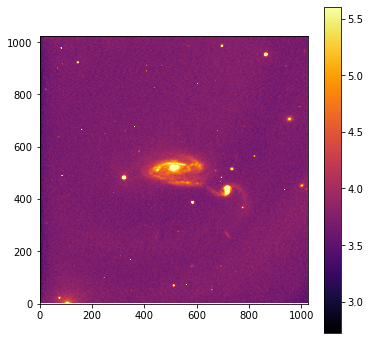

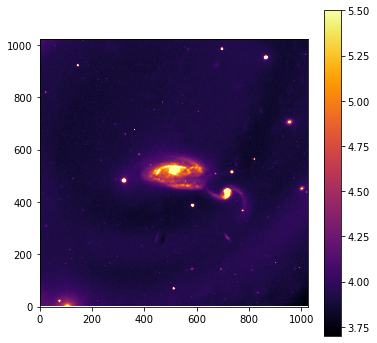

NGC 5395 V


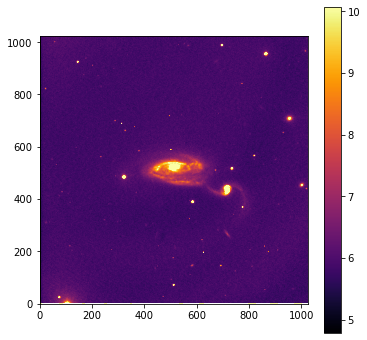

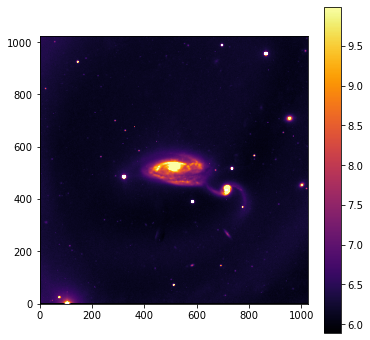

NGC 5395 Halpha


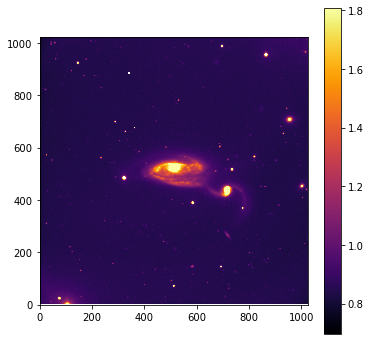

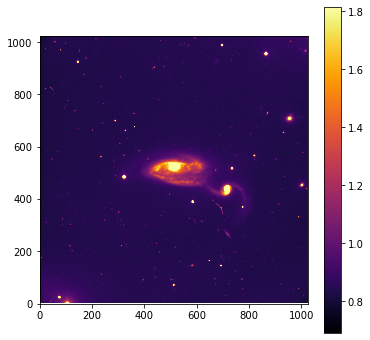

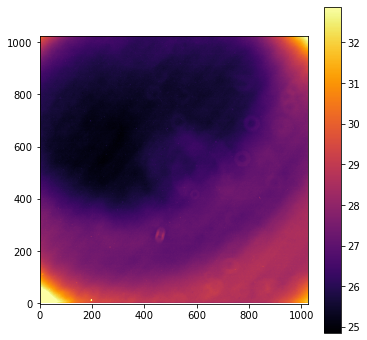

In [25]:
for key, value in sci_data.items():
    print(key)
    for i in value:
        my_plot(np.array(i))
   # my_plot(np.array(value)[1])
   # np.array(value).shape

In [26]:
# removing the damaged image of the H_Alpha filter
remove = sci_data['NGC 5395 Halpha'].pop()

### Sky substraction
In order to compute the typical counts coming from the sky I am using the class SkyInteractive so an interactive plot (whit higher contrast than normal) is display and using the sliders (x1, x2, y1, y2) we cut the image into 8 rectangles can be created, feeding those values to the function sky_squares_median the mode of every rectangle is computed and then the median of those modes is returned.

Here I'm using the default values (200, 900, 200, 750) as they work fine for every image and every filter but if needed feel free to play with it.

interactive(children=(IntSlider(value=200, description='x1', max=1023), IntSlider(value=900, description='x2',…

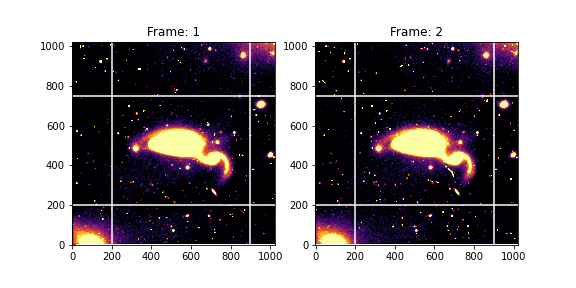

In [43]:
%matplotlib widget
halpha = SkyInteractive(sci_data['NGC 5395 Halpha'])
#.values() = (200, 900, 200, 750)

In [28]:
# %matplotlib widget
# ngcR = SkyInteractive(sci_data['NGC 5395 R'], (200, 900, 200, 750))

In [29]:
# %matplotlib widget
# ngcB = SkyInteractive(sci_data['NGC 5395 B'], (200, 900, 200, 750))

In [30]:
# %matplotlib widget
# ngcR = SkyInteractive(sci_data['NGC 5395 V'], (200, 900, 200, 750))

In [31]:
x1, x2, y1, y2 = halpha.get_cuts()

Checking the sky substraction

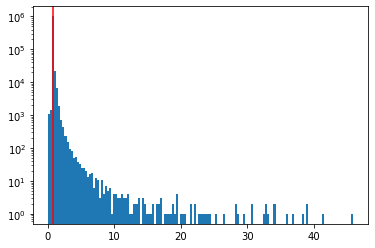

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
sci_data['NGC 5395 Halpha'][0][sci_data['NGC 5395 Halpha'][0] <= 0] = 0 
a = plt.hist(sci_data['NGC 5395 Halpha'][0].flatten(), bins = 150)
plt.yscale('log')
sky0 = sky_squares_median(x1, x2, y1, y2, sci_data['NGC 5395 Halpha'][0])
plt.axvline(sky0, color = 'r')
plt.show()

### Final reduction

In [33]:
def reduce_stack(x1, x2, y1, y2, data, exp_time):
    sky0 = sky_squares_median(x1, x2, y1, y2, data[0])
    sky1 = sky_squares_median(x1, x2, y1, y2, data[1])

    reduced_image0 = data[0] - sky0
    reduced_image1 = data[1] - sky1

    reduced_image0[reduced_image0 <= 0] = 0 + sky0/50 # to prevent infinite values in log plots
    reduced_image1[reduced_image1 <= 0] = 0 + sky1/50 # to prevent infinite values in log plots

    reduced_image0[np.isinf(reduced_image0)] = np.nan # to mark inf pixels as nan 
    reduced_image1[np.isinf(reduced_image1)] = np.nan # to mark inf pixels as nan        
    
    reduced = (exp_time[0] * reduced_image0 + exp_time[1] * reduced_image1) / np.sum(exp_time)
    my_plot(reduced)
    #my_plot_log(reduced)
    
    return reduced

#### H ALPHA

In [34]:
exp_time = hdu_science_info[hdu_science_info[:, 0] == 'NGC 5395 Halpha'][:, 3][:-1].astype('float64')
print('EXP TIMES: ', exp_time)

EXP TIMES:  [1200. 1200.]


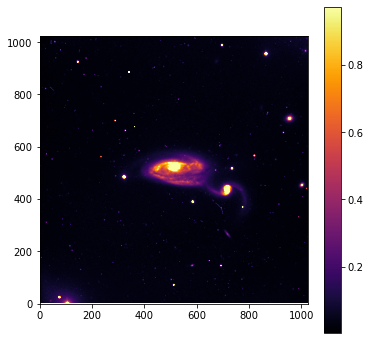

In [35]:
%matplotlib inline
reduce_halpha = reduce_stack(x1, x2, y1, y2, sci_data['NGC 5395 Halpha'], exp_time)

#### NGC 5395 R

In [36]:
exp_time = hdu_science_info[hdu_science_info[:, 0] == 'NGC 5395 R'][:, 3].astype('float64')
print('EXP TIMES: ', exp_time)

EXP TIMES:  [ 60. 900.]


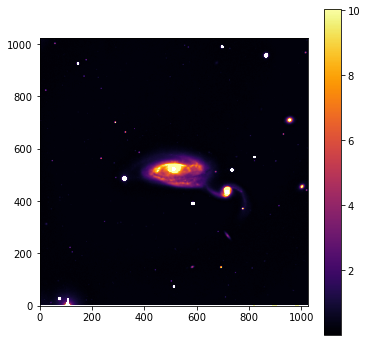

In [37]:
%matplotlib inline
reduce_ngcR = reduce_stack(x1, x2, y1, y2, sci_data['NGC 5395 R'], exp_time)

#### NGC 5395 V

In [38]:
exp_time = hdu_science_info[hdu_science_info[:, 0] == 'NGC 5395 V'][:, 3].astype('float64')
print('EXP TIMES: ', exp_time)

EXP TIMES:  [ 60. 900.]


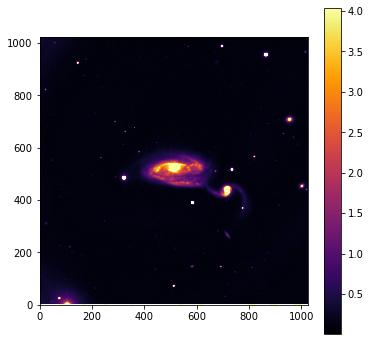

In [39]:
%matplotlib inline
reduce_ngcV = reduce_stack(x1, x2, y1, y2, sci_data['NGC 5395 V'], exp_time)

#### NGC 5395 B

In [40]:
exp_time = hdu_science_info[hdu_science_info[:, 0] == 'NGC 5395 B'][:, 3].astype('float64')
print('EXP TIMES: ', exp_time)

EXP TIMES:  [ 60. 900.]


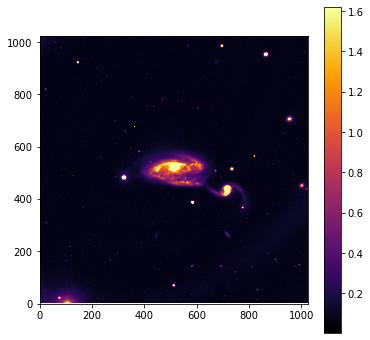

In [41]:
%matplotlib inline
reduce_ngcB = reduce_stack(x1, x2, y1, y2, sci_data['NGC 5395 B'], exp_time)

## Calibracion en flujo

In [42]:
Image(url = 'Images/estrellas_calibracion.png', width = 500, height = 200)

In [1]:
"""from ipywidgets import interactive
%matplotlib widget

data = reduce_ngcB
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
      
pos = []
def onclick(event):
    pos.append([event.xdata,event.ydata])
    print(pos)

    axes[0].imshow(data, origin = 'lower', 
                    vmin = np.nanpercentile(data, 0.25),
                    vmax = np.nanpercentile(data, 99.9),
                    cmap = 'inferno')
fig.canvas.mpl_connect('button_press_event', onclick)

    
def update(pos):         
    if len(pos) != 0:
        axes[1].imshow(data, origin = 'lower', 
                vmin = np.nanpercentile(data, 0.25),
                vmax = np.nanpercentile(data, 99.9),
                cmap = 'inferno')
        pos.clear()
    fig.canvas.draw_idle()
        
widget = interactive(onclick)
display(widget)"""

"from ipywidgets import interactive\n%matplotlib widget\n\ndata = reduce_ngcB\nfig, axes = plt.subplots(1, 2, figsize = (8, 4))\n      \npos = []\ndef onclick(event):\n    pos.append([event.xdata,event.ydata])\n    print(pos)\n\n    axes[0].imshow(data, origin = 'lower', \n                    vmin = np.nanpercentile(data, 0.25),\n                    vmax = np.nanpercentile(data, 99.9),\n                    cmap = 'inferno')\nfig.canvas.mpl_connect('button_press_event', onclick)\n\n    \ndef update(pos):         \n    if len(pos) != 0:\n        axes[1].imshow(data, origin = 'lower', \n                vmin = np.nanpercentile(data, 0.25),\n                vmax = np.nanpercentile(data, 99.9),\n                cmap = 'inferno')\n        pos.clear()\n    fig.canvas.draw_idle()\n        \nwidget = interactive(onclick)\ndisplay(widget)"

In [72]:
pos

[[521.2180919578852, 545.8997440938847],
 [470.75214213709677, 415.10887547829327],
 [501.03171202956986, 521.0873701019492]]

### TO DO: 

ahora tenemos el mismo corte para ambas imagenes de un filtro, me falta restarle el cielo mirar como ahcer un map para que me lo haga todo de un paso sin bucles for, e intentar que el recorte del cielo le sea más ameno al que lo este haciendo

## Calibracion en flujo:
- restar el cielo
- symbad stradburgo astronomical database
- abrir la foto del archivo
- coger una estrella y buscarla en symbad basic search
- escontrar esa estrella en la imagen y ver su magnitud
- repetirlo para por lo menos cuatro estrellas \
https://photutils.readthedocs.io/en/stable/api/photutils.aperture.CircularAperture.html#photutils.aperture.CircularAperture
- https://photutils.readthedocs.io/en/stable/aperture.html
Performing Aperture Photometry
una vez hecha la tabla el aperture_sum representa las cuentas por segundo
- imagen B-V
- (B-V).flatten frente R.flatten scatter
regiones azules son SFR, las mas rojas son estrellas mas viejas en R cuanto mayor mas masa